**Задача:** необходимо спрогнозировать цену автомобиля в зависимости от его характеристик

**Датасет:** за основу взяты [данные](https://www.kaggle.com/olegkiselev/avitoautotrain), полученные с помощью парсинга сайта Авито и находящиеся в открытом доступе

In [1]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
from tqdm import tqdm_notebook

from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_absolute_percentage_error

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import StringLookup

import warnings


SEED = 42
cv = KFold(n_splits=3, shuffle=True, random_state=SEED)
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('avito_train_utf8.csv')

In [3]:
data.columns

Index(['bodyType', 'brand', 'color', 'fuelType', 'modelDate', 'name',
       'numberOfDoors', 'productionDate', 'vehicleConfiguration',
       'vehicleTransmission', 'engineDisplacement', 'enginePower',
       'description', 'mileage', 'Комплектация', 'Привод', 'Руль', 'Состояние',
       'Владельцы', 'ПТС', 'Таможня', 'Владение', 'id', 'price', 'url'],
      dtype='object')

Сразу разобьем данные на train/oos и проверим на наличие дубликатов по полю **id** (если есть, то избавимся от них)

In [4]:
n_duplicates = data.shape[0] - data.id.drop_duplicates().shape[0]
print(f'Дубликатов в датасете {n_duplicates} штук')
if n_duplicates > 0:
    data = data.drop_duplicates()
train, test = train_test_split(data, shuffle=True, random_state=SEED, test_size=0.2)
train.reset_index(inplace=True, drop=True)
test.reset_index(inplace=True, drop=True)

Дубликатов в датасете 101 штук


Посмотрим на данные:

In [5]:
columns = train.columns.tolist()
train[columns[::2]].head()

,bodyType,color,modelDate,numberOfDoors,vehicleConfiguration,engineDisplacement,description,Комплектация,Руль,Владельцы,Таможня,id,url
0,внедорожник 5.0 дв.,чёрный,2006.0,5.0,внедорожник автомат 2.5,2.5 LTR,Оригинальный ПТС. Кузов в родной краске. Не уч...,LX,левый,2,Растаможен,38928,https://www.avito.ru/samara/avtomobili/kia_sor...
1,седан 4.0 дв.,белый,2009.0,4.0,седан механика 1.6,1.6 LTR,"Компрессия 12/4,есть проблемы по кузову, в хор...",Base,левый,1,Растаможен,41876,https://www.avito.ru/moskva/avtomobili/chevrol...
2,внедорожник 5.0 дв.,серый,2007.0,5.0,внедорожник автомат 2.3,2.3 LTR,Оригинальный ПТС. Кузов в родной краске. Не уч...,Базовая,левый,3,Растаможен,7481,https://www.avito.ru/koltushi/avtomobili/ford_...
3,седан 4.0 дв.,серый,2016.0,4.0,седан автомат 2.0,2.0 LTR,"В хорошем состоянии, в хорошей комплектаций в ...",M Sport,левый,1,Растаможен,44696,https://www.avito.ru/moskva/avtomobili/bmw_5_s...
4,минивэн,серый,2003.0,5.0,минивэн автомат 2.4,2.4 LTR,✅ УСПЕЙ КУПИТЬ ИЛИ ЗАБРОНИРОВАТЬ АВТОМОБИЛЬ ПО...,Базовая,правый,3,Растаможен,23321,https://www.avito.ru/chelyabinsk/avtomobili/mi...


In [6]:
train[columns[1::2]].head()

,brand,fuelType,name,productionDate,vehicleTransmission,enginePower,mileage,Привод,Состояние,ПТС,Владение,price
0,KIA,дизель,2.5 CRDi 4WD AT (170 л.с.),2006.0,автоматическая,170 N12,175000.0,полный,не битый,Оригинал,7 лет 3 месяца,550000.0
1,Chevrolet,бензин,1.6 MT (109 л.с.),2009.0,механическая,109 N12,311000.0,передний,битый,Оригинал,11 лет 6 месяцев,250000.0
2,Ford,бензин,2.3 AT (155 л.с.),2007.0,автоматическая,155 N12,173000.0,передний,не битый,Оригинал,4 года 2 месяца,430000.0
3,BMW,дизель,520d 2.0 xDrive Steptronic (190 л.с.),2016.0,автоматическая,190 N12,77000.0,полный,не битый,Оригинал,4 года 6 месяцев,2150000.0
4,Mitsubishi,бензин,2.4 4WD AT (165 л.с.),2003.0,автоматическая,165 N12,250000.0,полный,не битый,Оригинал,6 лет 2 месяца,329900.0


Видно, что некоторая информация в колонках дублируется с некоторыми изменениями (иногда более удобными для дальнейшего преобразования фичей):

* информация из **name** содержится в **vehicleConfiguration**, **Привод**, **engineDisplacement**, **vehicleTransmission** и **enginePower**
* информация из **bodyType** содержится в **vehicleConfiguration** и **numberOfDoors**

А фичи **modelDate** и **productionDate** равны:

In [7]:
all(train.modelDate == train.productionDate)

True

Оставим следующие фичи без изменений:

* **color**
* **brand**
* **modelDate**
* **fuelType**
* **numberOfDoors**
* **description**
* **Комплектация**
* **Руль**
* **Владельцы**
* **Таможня**
* **vehicleTransmission**
* **mileage**
* **Привод**
* **Состояние**
* **ПТС**

Из остальных сгенерируем новые фичи:

In [8]:
# Из vehicleConfiguration можно вытащить информацию о типе машины, коробке (есть в явном виде в vehicleTransmission)
# и объеме двигателя
info = train.vehicleConfiguration.apply(lambda x: len(str(x).split()))
info.value_counts()

3    36497
1        5
Name: vehicleConfiguration, dtype: int64

In [9]:
train.vehicleConfiguration[info < 3]

3814     NaN
3938     NaN
6546     NaN
6951     NaN
16364    NaN
Name: vehicleConfiguration, dtype: object

In [10]:
# Видим, что строки с длиной меньше 3 пусты
for num, new_col in enumerate(['machine_type', 'engine_volume']):
    if num == 0:
        train[new_col] = train.vehicleConfiguration.apply(lambda x: x.split()[0] if type(x) is str else np.nan)
        test[new_col] = test.vehicleConfiguration.apply(lambda x: x.split()[0] if type(x) is str else np.nan)
    else:
        train[new_col] = train.vehicleConfiguration.apply(lambda x: x.split()[2] if type(x) is str else np.nan).astype('float')
        test[new_col] = test.vehicleConfiguration.apply(lambda x: x.split()[2] if type(x) is str else np.nan).astype('float')

In [11]:
train.head()

,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,...,Состояние,Владельцы,ПТС,Таможня,Владение,id,price,url,machine_type,engine_volume
0,внедорожник 5.0 дв.,KIA,чёрный,дизель,2006.0,2.5 CRDi 4WD AT (170 л.с.),5.0,2006.0,внедорожник автомат 2.5,автоматическая,...,не битый,2,Оригинал,Растаможен,7 лет 3 месяца,38928,550000.0,https://www.avito.ru/samara/avtomobili/kia_sor...,внедорожник,2.5
1,седан 4.0 дв.,Chevrolet,белый,бензин,2009.0,1.6 MT (109 л.с.),4.0,2009.0,седан механика 1.6,механическая,...,битый,1,Оригинал,Растаможен,11 лет 6 месяцев,41876,250000.0,https://www.avito.ru/moskva/avtomobili/chevrol...,седан,1.6
2,внедорожник 5.0 дв.,Ford,серый,бензин,2007.0,2.3 AT (155 л.с.),5.0,2007.0,внедорожник автомат 2.3,автоматическая,...,не битый,3,Оригинал,Растаможен,4 года 2 месяца,7481,430000.0,https://www.avito.ru/koltushi/avtomobili/ford_...,внедорожник,2.3
3,седан 4.0 дв.,BMW,серый,дизель,2016.0,520d 2.0 xDrive Steptronic (190 л.с.),4.0,2016.0,седан автомат 2.0,автоматическая,...,не битый,1,Оригинал,Растаможен,4 года 6 месяцев,44696,2150000.0,https://www.avito.ru/moskva/avtomobili/bmw_5_s...,седан,2.0
4,минивэн,Mitsubishi,серый,бензин,2003.0,2.4 4WD AT (165 л.с.),5.0,2003.0,минивэн автомат 2.4,автоматическая,...,не битый,3,Оригинал,Растаможен,6 лет 2 месяца,23321,329900.0,https://www.avito.ru/chelyabinsk/avtomobili/mi...,минивэн,2.4


In [12]:
info = train.enginePower.apply(lambda x: len(str(x).split()))
print(info.value_counts())
train['engine_power'] = train.enginePower.apply(lambda x: x.split()[0] if (type(x) is str) and (len(x.split())>1) else np.nan)
test['engine_power'] = test.enginePower.apply(lambda x: x.split()[0] if (type(x) is str) and (len(x.split())>1) else np.nan)

2    36466
1       36
Name: enginePower, dtype: int64


In [13]:
info = train.Владение.apply(lambda x: len(str(x).split()))
print(info.value_counts())
# заменим на число месяцев в пользовании (last usage time)
train['last_usage'] = train.Владение.apply(lambda x: int(x.split()[0]) * 12 + int(x.split()[2]) \
                                           if (type(x) is str) and (len(x.split()) == 4) else \
                                           (int(x.split()[0]) if (type(x) is str) and (len(x.split()) == 2) else np.nan))
test['last_usage'] = test.Владение.apply(lambda x: int(x.split()[0]) * 12 + int(x.split()[2]) \
                                           if (type(x) is str) and (len(x.split()) == 4) else \
                                           (int(x.split()[0]) if (type(x) is str) and (len(x.split()) == 2) else np.nan))

4    34255
1     2233
2       14
Name: Владение, dtype: int64


<AxesSubplot:>

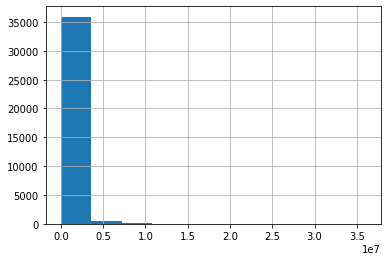

In [14]:
train['price'].hist() 
# Приведем таргет к нормальному распределению для улучшения сходимости
train['price_log'] = np.log(train.price)
train['price_log'].hist() 

<AxesSubplot:>

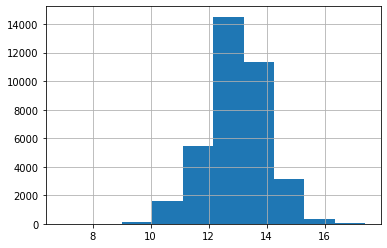

In [15]:
train['price_log'].hist() 

In [16]:
mapping = {'Комплектация': 'complectation', 'fuelType': 'fuel_type', 'Руль': 'wheel', 
           'Таможня': 'customs', 'vehicleTransmission': 'vehicle_transmission', 
           'Привод': 'drive', 'Состояние': 'status', 'ПТС': 'pts', 'modelDate': 'model_date',
           'numberOfDoors': 'number_of_doors', 'Владельцы': 'owners'}
# комплектация в итоговом списке факторов не участвует, поскольку у каждой марки своя классификация комплектаций,
# в качестве дальнейшего улучшения модели можно создать обобщающую шкалу 
cat_feat_list = ['color', 'brand', 'fuel_type', 'wheel', 
                 'customs', 'vehicle_transmission', 'drive', 'status', 
                 'pts', 'machine_type']
num_feat_list = ['model_date', 'number_of_doors', 'owners', 'mileage', 'engine_volume', 'engine_power', 'last_usage']
text_feat = 'description'
target = 'price_log'
train.rename(columns=mapping, inplace=True)
test.rename(columns=mapping, inplace=True)

# заполним пропуски
train.loc[:, cat_feat_list] = train.loc[:, cat_feat_list].fillna('Empty')
test.loc[:, cat_feat_list] = test.loc[:, cat_feat_list].fillna('Empty')
train.loc[:, num_feat_list] = train.loc[:, num_feat_list].fillna(-1).astype('float32')
test.loc[:, num_feat_list] = test.loc[:, num_feat_list].fillna(-1).astype('float32')
train.loc[:, text_feat] = train.loc[:, text_feat].fillna('Empty')
test.loc[:, text_feat] = test.loc[:, text_feat].fillna('Empty')

In [17]:
def encode_categorical_feature(feature, name, dataset):
    lookup = StringLookup(output_mode="binary")

    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    lookup.adapt(feature_ds)

    encoded_feature = lookup(feature)
    return layers.Dense(encoded_feature.shape[1], activation="relu")(encoded_feature)

def encode_numerical_feature(feature):
    return layers.Dense(feature.shape[1], activation="relu")(feature)

In [18]:
def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe[target]
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe[num_feat_list + cat_feat_list]), labels))
    return ds

def test_to_dataset(dataframe):
    dataframe = dataframe.copy()
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe[num_feat_list + cat_feat_list]), ))
    return ds

In [19]:
train_score = []
valid_score = []
for train_index, valid_index in cv.split(train):
    
    train_ds = dataframe_to_dataset(train.loc[train_index, num_feat_list + cat_feat_list + [target]])
    valid_ds = test_to_dataset(train.loc[valid_index, num_feat_list + cat_feat_list])
    train_ds = train_ds.batch(32)
    valid_ds = valid_ds.batch(32)
    
    for feature in num_feat_list:
        globals()[feature] = keras.Input(shape=(1,), name=feature)
    for feature in cat_feat_list:
        globals()[feature] = keras.Input(shape=(1,), name=feature, dtype="string")
    
    
    all_inputs = [globals()[feature] for feature in num_feat_list + cat_feat_list]
    
    # Integer categorical features
    for feature in num_feat_list:
        globals()[feature + '_encoded'] = encode_numerical_feature(globals()[feature])
    for feature in cat_feat_list:
        globals()[feature + '_encoded'] = encode_categorical_feature(globals()[feature], feature, train_ds)
    
    
    all_features = layers.concatenate(
        [globals()[feature + '_encoded'] for feature in num_feat_list + cat_feat_list]
    )
    x = layers.Dense(1024, activation="relu")(all_features)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(512, activation="relu")(x)
    output = layers.Dense(1, activation="linear")(x)
    model = keras.Model(all_inputs, output)
    model.compile("adam", "mean_absolute_percentage_error")
    model.fit(train_ds, epochs=10, workers=16, batch_size=32, use_multiprocessing=True)
    train_score.append(mean_absolute_percentage_error(train.loc[train_index, 'price'], np.exp(model.predict(train_ds))))
    valid_score.append(mean_absolute_percentage_error(train.loc[valid_index, 'price'], np.exp(model.predict(valid_ds))))

Epoch 1/10
761/761 [==============================] - 7s 6ms/step - loss: 69.1853
Epoch 2/10
761/761 [==============================] - 5s 7ms/step - loss: 10.0949
Epoch 3/10
761/761 [==============================] - 5s 6ms/step - loss: 5.8077
Epoch 4/10
761/761 [==============================] - 5s 7ms/step - loss: 4.6746
Epoch 5/10
761/761 [==============================] - 5s 7ms/step - loss: 4.6678
Epoch 6/10
761/761 [==============================] - 6s 8ms/step - loss: 4.6332
Epoch 7/10
761/761 [==============================] - 7s 9ms/step - loss: 4.6111
Epoch 8/10
761/761 [==============================] - 7s 9ms/step - loss: 4.6637
Epoch 9/10
761/761 [==============================] - 7s 9ms/step - loss: 4.3719
Epoch 10/10
761/761 [==============================] - 5s 7ms/step - loss: 4.4288
Epoch 1/10
761/761 [==============================] - 6s 6ms/step - loss: 2847.2551
Epoch 2/10
761/761 [==============================] - 5s 7ms/step - loss: 274.0377
Epoch 3/10
761/761 [

In [20]:
print(f'Средняя метрика MAPE на train {np.mean(train_score)}, std {np.std(train_score)}')
print(f'Средняя метрика MAPE на test {np.mean(valid_score)}, std {np.std(valid_score)}')

Средняя метрика MAPE на train 0.8895087457354601, std 0.40464336358143826
Средняя метрика MAPE на test 0.8399525836214036, std 0.3575690154400788


Попробуем иные методы машинного обучения.

In [21]:
train_score = []
valid_score = []
for train_index, valid_index in tqdm_notebook(cv.split(train)):
    
    cls = CatBoostRegressor(verbose=False)
    cls.fit(train.loc[train_index, num_feat_list + cat_feat_list], train.loc[train_index, target], cat_features=cat_feat_list)
    train_score.append(mean_absolute_percentage_error(train.loc[train_index, 'price'], np.exp(cls.predict(train.loc[train_index, num_feat_list + cat_feat_list]))))
    valid_score.append(mean_absolute_percentage_error(train.loc[valid_index, 'price'], np.exp(cls.predict(train.loc[valid_index, num_feat_list + cat_feat_list]))))

0it [00:00, ?it/s]

In [22]:
print(f'Средняя метрика MAPE на train {np.mean(train_score)}, std {np.std(train_score)}')
print(f'Средняя метрика MAPE на test {np.mean(valid_score)}, std {np.std(valid_score)}')

Средняя метрика MAPE на train 0.19284033035513692, std 0.0032498516460993877
Средняя метрика MAPE на test 0.2198770943321342, std 0.005359906156494953


Катбуст показал лучшее качество на кросс-валидации. Конечно, можно провести подбор архитектуры нейронной сети и, наверное, получить качество на уровне или лучше бустинга, но работу продолжим именно с бустингом.

На данный момент незадействованным оказалось текстовое поле из объявления. Обучим tfidf+LinearRegression на данном поле и подадим результат  бустинг как доп. фичу.

In [23]:
train_score = []
valid_score = []
for train_index, valid_index in cv.split(train):
    tfidf = TfidfVectorizer(ngram_range=(1, 2), lowercase=True, max_features=10000, max_df=0.7)
    tfidf_train = tfidf.fit_transform(train.loc[train_index, text_feat])
    tfidf_valid = tfidf.transform(train.loc[valid_index, text_feat])
    lr = LinearRegression()
    lr.fit(tfidf_train, train.loc[train_index, target])
    lr_train = lr.predict(tfidf_train)
    lr_valid = lr.predict(tfidf_valid)
    train.loc[train_index, 'lr'] = lr_train
    train.loc[valid_index, 'lr'] = lr_valid
    cls = CatBoostRegressor()
    cls.fit(train.loc[train_index, num_feat_list + cat_feat_list+['lr']], train.loc[train_index, target], cat_features=cat_feat_list)
    train_score.append(mean_absolute_percentage_error(train.loc[train_index, 'price'], 
                                                      np.exp(cls.predict(train.loc[train_index, num_feat_list + cat_feat_list+['lr']]))))
    valid_score.append(mean_absolute_percentage_error(train.loc[valid_index, 'price'], 
                                                      np.exp(cls.predict(train.loc[valid_index, num_feat_list + cat_feat_list+['lr']]))))

Learning rate set to 0.068889
0:	learn: 0.9632469	total: 19.6ms	remaining: 19.6s
1:	learn: 0.9121071	total: 32.5ms	remaining: 16.2s
2:	learn: 0.8659580	total: 46.9ms	remaining: 15.6s
3:	learn: 0.8236026	total: 59.1ms	remaining: 14.7s
4:	learn: 0.7833263	total: 71.5ms	remaining: 14.2s
5:	learn: 0.7465113	total: 84ms	remaining: 13.9s
6:	learn: 0.7134708	total: 95.6ms	remaining: 13.6s
7:	learn: 0.6813062	total: 109ms	remaining: 13.5s
8:	learn: 0.6520863	total: 121ms	remaining: 13.3s
9:	learn: 0.6243214	total: 133ms	remaining: 13.2s
10:	learn: 0.5995293	total: 146ms	remaining: 13.1s
11:	learn: 0.5780525	total: 164ms	remaining: 13.5s
12:	learn: 0.5570016	total: 179ms	remaining: 13.6s
13:	learn: 0.5367213	total: 191ms	remaining: 13.5s
14:	learn: 0.5181721	total: 208ms	remaining: 13.6s
15:	learn: 0.5014494	total: 225ms	remaining: 13.8s
16:	learn: 0.4863841	total: 237ms	remaining: 13.7s
17:	learn: 0.4718549	total: 249ms	remaining: 13.6s
18:	learn: 0.4585060	total: 260ms	remaining: 13.4s
19:	le

176:	learn: 0.2638485	total: 2.25s	remaining: 10.4s
177:	learn: 0.2635619	total: 2.26s	remaining: 10.4s
178:	learn: 0.2633389	total: 2.27s	remaining: 10.4s
179:	learn: 0.2630600	total: 2.28s	remaining: 10.4s
180:	learn: 0.2627980	total: 2.29s	remaining: 10.4s
181:	learn: 0.2626719	total: 2.31s	remaining: 10.4s
182:	learn: 0.2625762	total: 2.32s	remaining: 10.3s
183:	learn: 0.2623947	total: 2.33s	remaining: 10.3s
184:	learn: 0.2621816	total: 2.34s	remaining: 10.3s
185:	learn: 0.2620199	total: 2.35s	remaining: 10.3s
186:	learn: 0.2617478	total: 2.37s	remaining: 10.3s
187:	learn: 0.2615825	total: 2.38s	remaining: 10.3s
188:	learn: 0.2613585	total: 2.39s	remaining: 10.2s
189:	learn: 0.2611901	total: 2.4s	remaining: 10.2s
190:	learn: 0.2609307	total: 2.41s	remaining: 10.2s
191:	learn: 0.2608343	total: 2.42s	remaining: 10.2s
192:	learn: 0.2606369	total: 2.43s	remaining: 10.2s
193:	learn: 0.2604380	total: 2.44s	remaining: 10.1s
194:	learn: 0.2603126	total: 2.46s	remaining: 10.2s
195:	learn: 0

336:	learn: 0.2439945	total: 4.09s	remaining: 8.06s
337:	learn: 0.2439536	total: 4.11s	remaining: 8.05s
338:	learn: 0.2438998	total: 4.13s	remaining: 8.04s
339:	learn: 0.2437841	total: 4.14s	remaining: 8.03s
340:	learn: 0.2437775	total: 4.15s	remaining: 8.01s
341:	learn: 0.2436027	total: 4.16s	remaining: 8s
342:	learn: 0.2434175	total: 4.17s	remaining: 7.99s
343:	learn: 0.2433295	total: 4.19s	remaining: 7.99s
344:	learn: 0.2432202	total: 4.2s	remaining: 7.97s
345:	learn: 0.2430990	total: 4.21s	remaining: 7.96s
346:	learn: 0.2430396	total: 4.22s	remaining: 7.94s
347:	learn: 0.2429298	total: 4.23s	remaining: 7.93s
348:	learn: 0.2427895	total: 4.24s	remaining: 7.91s
349:	learn: 0.2426430	total: 4.25s	remaining: 7.9s
350:	learn: 0.2425716	total: 4.27s	remaining: 7.9s
351:	learn: 0.2424405	total: 4.29s	remaining: 7.89s
352:	learn: 0.2423632	total: 4.3s	remaining: 7.88s
353:	learn: 0.2423105	total: 4.32s	remaining: 7.88s
354:	learn: 0.2423017	total: 4.33s	remaining: 7.86s
355:	learn: 0.24226

508:	learn: 0.2321967	total: 6.37s	remaining: 6.14s
509:	learn: 0.2321064	total: 6.38s	remaining: 6.13s
510:	learn: 0.2320920	total: 6.4s	remaining: 6.12s
511:	learn: 0.2320735	total: 6.41s	remaining: 6.11s
512:	learn: 0.2320047	total: 6.43s	remaining: 6.1s
513:	learn: 0.2319711	total: 6.44s	remaining: 6.08s
514:	learn: 0.2319518	total: 6.45s	remaining: 6.07s
515:	learn: 0.2318770	total: 6.46s	remaining: 6.06s
516:	learn: 0.2318510	total: 6.47s	remaining: 6.04s
517:	learn: 0.2318035	total: 6.48s	remaining: 6.03s
518:	learn: 0.2317387	total: 6.49s	remaining: 6.02s
519:	learn: 0.2317155	total: 6.5s	remaining: 6s
520:	learn: 0.2316615	total: 6.51s	remaining: 5.99s
521:	learn: 0.2315564	total: 6.53s	remaining: 5.97s
522:	learn: 0.2314664	total: 6.54s	remaining: 5.96s
523:	learn: 0.2314458	total: 6.55s	remaining: 5.95s
524:	learn: 0.2314214	total: 6.56s	remaining: 5.93s
525:	learn: 0.2313941	total: 6.57s	remaining: 5.92s
526:	learn: 0.2313633	total: 6.58s	remaining: 5.91s
527:	learn: 0.2313

675:	learn: 0.2235449	total: 8.62s	remaining: 4.13s
676:	learn: 0.2235319	total: 8.63s	remaining: 4.12s
677:	learn: 0.2234954	total: 8.65s	remaining: 4.11s
678:	learn: 0.2234424	total: 8.66s	remaining: 4.09s
679:	learn: 0.2234097	total: 8.68s	remaining: 4.08s
680:	learn: 0.2233631	total: 8.69s	remaining: 4.07s
681:	learn: 0.2233278	total: 8.7s	remaining: 4.06s
682:	learn: 0.2232842	total: 8.73s	remaining: 4.05s
683:	learn: 0.2232551	total: 8.74s	remaining: 4.04s
684:	learn: 0.2231955	total: 8.75s	remaining: 4.03s
685:	learn: 0.2231513	total: 8.77s	remaining: 4.01s
686:	learn: 0.2231128	total: 8.78s	remaining: 4s
687:	learn: 0.2230989	total: 8.79s	remaining: 3.99s
688:	learn: 0.2230861	total: 8.8s	remaining: 3.97s
689:	learn: 0.2230363	total: 8.81s	remaining: 3.96s
690:	learn: 0.2229606	total: 8.83s	remaining: 3.95s
691:	learn: 0.2228826	total: 8.85s	remaining: 3.94s
692:	learn: 0.2228319	total: 8.87s	remaining: 3.93s
693:	learn: 0.2228244	total: 8.88s	remaining: 3.92s
694:	learn: 0.222

846:	learn: 0.2168324	total: 10.9s	remaining: 1.97s
847:	learn: 0.2167942	total: 10.9s	remaining: 1.95s
848:	learn: 0.2167797	total: 10.9s	remaining: 1.94s
849:	learn: 0.2167355	total: 10.9s	remaining: 1.93s
850:	learn: 0.2167184	total: 10.9s	remaining: 1.91s
851:	learn: 0.2166268	total: 10.9s	remaining: 1.9s
852:	learn: 0.2166214	total: 11s	remaining: 1.89s
853:	learn: 0.2165769	total: 11s	remaining: 1.88s
854:	learn: 0.2165319	total: 11s	remaining: 1.86s
855:	learn: 0.2164911	total: 11s	remaining: 1.85s
856:	learn: 0.2164747	total: 11s	remaining: 1.84s
857:	learn: 0.2164212	total: 11s	remaining: 1.83s
858:	learn: 0.2163936	total: 11.1s	remaining: 1.81s
859:	learn: 0.2163581	total: 11.1s	remaining: 1.8s
860:	learn: 0.2163354	total: 11.1s	remaining: 1.79s
861:	learn: 0.2162983	total: 11.1s	remaining: 1.78s
862:	learn: 0.2162521	total: 11.1s	remaining: 1.77s
863:	learn: 0.2162274	total: 11.2s	remaining: 1.76s
864:	learn: 0.2162202	total: 11.2s	remaining: 1.74s
865:	learn: 0.2162067	tota

13:	learn: 0.5322810	total: 199ms	remaining: 14s
14:	learn: 0.5151265	total: 210ms	remaining: 13.8s
15:	learn: 0.4981117	total: 225ms	remaining: 13.9s
16:	learn: 0.4828812	total: 238ms	remaining: 13.8s
17:	learn: 0.4692684	total: 252ms	remaining: 13.7s
18:	learn: 0.4557245	total: 273ms	remaining: 14.1s
19:	learn: 0.4436360	total: 287ms	remaining: 14.1s
20:	learn: 0.4324631	total: 299ms	remaining: 13.9s
21:	learn: 0.4226748	total: 312ms	remaining: 13.8s
22:	learn: 0.4134046	total: 325ms	remaining: 13.8s
23:	learn: 0.4050721	total: 336ms	remaining: 13.7s
24:	learn: 0.3968711	total: 348ms	remaining: 13.6s
25:	learn: 0.3896326	total: 361ms	remaining: 13.5s
26:	learn: 0.3833336	total: 373ms	remaining: 13.4s
27:	learn: 0.3773897	total: 385ms	remaining: 13.4s
28:	learn: 0.3714007	total: 398ms	remaining: 13.3s
29:	learn: 0.3665254	total: 409ms	remaining: 13.2s
30:	learn: 0.3620631	total: 422ms	remaining: 13.2s
31:	learn: 0.3578629	total: 434ms	remaining: 13.1s
32:	learn: 0.3538681	total: 445ms

180:	learn: 0.2624078	total: 2.43s	remaining: 11s
181:	learn: 0.2623687	total: 2.44s	remaining: 11s
182:	learn: 0.2621676	total: 2.46s	remaining: 11s
183:	learn: 0.2619948	total: 2.47s	remaining: 10.9s
184:	learn: 0.2617781	total: 2.48s	remaining: 10.9s
185:	learn: 0.2617019	total: 2.49s	remaining: 10.9s
186:	learn: 0.2615113	total: 2.5s	remaining: 10.9s
187:	learn: 0.2613744	total: 2.52s	remaining: 10.9s
188:	learn: 0.2611778	total: 2.53s	remaining: 10.8s
189:	learn: 0.2609955	total: 2.54s	remaining: 10.8s
190:	learn: 0.2608921	total: 2.55s	remaining: 10.8s
191:	learn: 0.2607095	total: 2.56s	remaining: 10.8s
192:	learn: 0.2605628	total: 2.58s	remaining: 10.8s
193:	learn: 0.2602400	total: 2.59s	remaining: 10.8s
194:	learn: 0.2600273	total: 2.6s	remaining: 10.7s
195:	learn: 0.2598586	total: 2.61s	remaining: 10.7s
196:	learn: 0.2597286	total: 2.62s	remaining: 10.7s
197:	learn: 0.2595424	total: 2.64s	remaining: 10.7s
198:	learn: 0.2593708	total: 2.65s	remaining: 10.7s
199:	learn: 0.259154

341:	learn: 0.2440490	total: 4.49s	remaining: 8.63s
342:	learn: 0.2439866	total: 4.5s	remaining: 8.62s
343:	learn: 0.2439379	total: 4.51s	remaining: 8.6s
344:	learn: 0.2438368	total: 4.53s	remaining: 8.59s
345:	learn: 0.2437577	total: 4.54s	remaining: 8.57s
346:	learn: 0.2436450	total: 4.55s	remaining: 8.56s
347:	learn: 0.2435564	total: 4.56s	remaining: 8.55s
348:	learn: 0.2434848	total: 4.58s	remaining: 8.54s
349:	learn: 0.2433172	total: 4.59s	remaining: 8.52s
350:	learn: 0.2432465	total: 4.6s	remaining: 8.51s
351:	learn: 0.2431659	total: 4.61s	remaining: 8.49s
352:	learn: 0.2430359	total: 4.63s	remaining: 8.48s
353:	learn: 0.2429529	total: 4.64s	remaining: 8.47s
354:	learn: 0.2429457	total: 4.65s	remaining: 8.45s
355:	learn: 0.2428425	total: 4.66s	remaining: 8.44s
356:	learn: 0.2427541	total: 4.68s	remaining: 8.42s
357:	learn: 0.2426803	total: 4.69s	remaining: 8.41s
358:	learn: 0.2426521	total: 4.7s	remaining: 8.4s
359:	learn: 0.2425446	total: 4.71s	remaining: 8.38s
360:	learn: 0.242

511:	learn: 0.2322835	total: 6.76s	remaining: 6.44s
512:	learn: 0.2321902	total: 6.77s	remaining: 6.43s
513:	learn: 0.2321059	total: 6.78s	remaining: 6.41s
514:	learn: 0.2320279	total: 6.8s	remaining: 6.4s
515:	learn: 0.2319725	total: 6.8s	remaining: 6.38s
516:	learn: 0.2319380	total: 6.82s	remaining: 6.37s
517:	learn: 0.2319173	total: 6.83s	remaining: 6.36s
518:	learn: 0.2318400	total: 6.84s	remaining: 6.34s
519:	learn: 0.2317721	total: 6.86s	remaining: 6.33s
520:	learn: 0.2317526	total: 6.87s	remaining: 6.31s
521:	learn: 0.2317148	total: 6.88s	remaining: 6.3s
522:	learn: 0.2316443	total: 6.9s	remaining: 6.29s
523:	learn: 0.2316421	total: 6.91s	remaining: 6.28s
524:	learn: 0.2315748	total: 6.92s	remaining: 6.26s
525:	learn: 0.2315034	total: 6.94s	remaining: 6.25s
526:	learn: 0.2314152	total: 6.95s	remaining: 6.24s
527:	learn: 0.2313536	total: 6.96s	remaining: 6.22s
528:	learn: 0.2313006	total: 6.98s	remaining: 6.22s
529:	learn: 0.2312440	total: 7s	remaining: 6.21s
530:	learn: 0.231213

679:	learn: 0.2238858	total: 9.02s	remaining: 4.24s
680:	learn: 0.2238801	total: 9.03s	remaining: 4.23s
681:	learn: 0.2238665	total: 9.04s	remaining: 4.22s
682:	learn: 0.2238654	total: 9.07s	remaining: 4.21s
683:	learn: 0.2237948	total: 9.08s	remaining: 4.2s
684:	learn: 0.2237596	total: 9.09s	remaining: 4.18s
685:	learn: 0.2237573	total: 9.11s	remaining: 4.17s
686:	learn: 0.2237547	total: 9.13s	remaining: 4.16s
687:	learn: 0.2237179	total: 9.14s	remaining: 4.14s
688:	learn: 0.2236759	total: 9.15s	remaining: 4.13s
689:	learn: 0.2236402	total: 9.16s	remaining: 4.12s
690:	learn: 0.2236142	total: 9.18s	remaining: 4.11s
691:	learn: 0.2235918	total: 9.2s	remaining: 4.09s
692:	learn: 0.2235682	total: 9.21s	remaining: 4.08s
693:	learn: 0.2235007	total: 9.22s	remaining: 4.07s
694:	learn: 0.2234842	total: 9.24s	remaining: 4.05s
695:	learn: 0.2234780	total: 9.25s	remaining: 4.04s
696:	learn: 0.2234255	total: 9.26s	remaining: 4.03s
697:	learn: 0.2233786	total: 9.28s	remaining: 4.01s
698:	learn: 0.

846:	learn: 0.2172787	total: 11.3s	remaining: 2.03s
847:	learn: 0.2171922	total: 11.3s	remaining: 2.02s
848:	learn: 0.2171606	total: 11.3s	remaining: 2.01s
849:	learn: 0.2170912	total: 11.3s	remaining: 2s
850:	learn: 0.2170611	total: 11.3s	remaining: 1.98s
851:	learn: 0.2170345	total: 11.3s	remaining: 1.97s
852:	learn: 0.2169799	total: 11.3s	remaining: 1.96s
853:	learn: 0.2169653	total: 11.4s	remaining: 1.94s
854:	learn: 0.2168939	total: 11.4s	remaining: 1.93s
855:	learn: 0.2168740	total: 11.4s	remaining: 1.92s
856:	learn: 0.2168518	total: 11.4s	remaining: 1.9s
857:	learn: 0.2167674	total: 11.4s	remaining: 1.89s
858:	learn: 0.2167000	total: 11.4s	remaining: 1.88s
859:	learn: 0.2166599	total: 11.4s	remaining: 1.86s
860:	learn: 0.2166416	total: 11.5s	remaining: 1.85s
861:	learn: 0.2166063	total: 11.5s	remaining: 1.84s
862:	learn: 0.2165556	total: 11.5s	remaining: 1.82s
863:	learn: 0.2165432	total: 11.5s	remaining: 1.81s
864:	learn: 0.2165108	total: 11.5s	remaining: 1.8s
865:	learn: 0.216

12:	learn: 0.5539143	total: 210ms	remaining: 15.9s
13:	learn: 0.5344620	total: 221ms	remaining: 15.6s
14:	learn: 0.5165896	total: 236ms	remaining: 15.5s
15:	learn: 0.5001829	total: 248ms	remaining: 15.3s
16:	learn: 0.4843857	total: 264ms	remaining: 15.3s
17:	learn: 0.4703766	total: 275ms	remaining: 15s
18:	learn: 0.4575986	total: 286ms	remaining: 14.7s
19:	learn: 0.4460043	total: 296ms	remaining: 14.5s
20:	learn: 0.4347022	total: 308ms	remaining: 14.4s
21:	learn: 0.4248392	total: 319ms	remaining: 14.2s
22:	learn: 0.4154810	total: 331ms	remaining: 14s
23:	learn: 0.4069690	total: 342ms	remaining: 13.9s
24:	learn: 0.3985305	total: 353ms	remaining: 13.8s
25:	learn: 0.3908551	total: 363ms	remaining: 13.6s
26:	learn: 0.3838524	total: 376ms	remaining: 13.5s
27:	learn: 0.3774096	total: 390ms	remaining: 13.5s
28:	learn: 0.3716876	total: 402ms	remaining: 13.5s
29:	learn: 0.3663925	total: 413ms	remaining: 13.4s
30:	learn: 0.3617037	total: 425ms	remaining: 13.3s
31:	learn: 0.3575737	total: 436ms	r

179:	learn: 0.2595040	total: 2.27s	remaining: 10.4s
180:	learn: 0.2592881	total: 2.29s	remaining: 10.3s
181:	learn: 0.2590731	total: 2.3s	remaining: 10.3s
182:	learn: 0.2589993	total: 2.31s	remaining: 10.3s
183:	learn: 0.2589263	total: 2.32s	remaining: 10.3s
184:	learn: 0.2586230	total: 2.34s	remaining: 10.3s
185:	learn: 0.2584495	total: 2.35s	remaining: 10.3s
186:	learn: 0.2583622	total: 2.36s	remaining: 10.3s
187:	learn: 0.2582050	total: 2.37s	remaining: 10.3s
188:	learn: 0.2581125	total: 2.39s	remaining: 10.3s
189:	learn: 0.2581007	total: 2.4s	remaining: 10.2s
190:	learn: 0.2580213	total: 2.41s	remaining: 10.2s
191:	learn: 0.2580078	total: 2.42s	remaining: 10.2s
192:	learn: 0.2578024	total: 2.44s	remaining: 10.2s
193:	learn: 0.2577915	total: 2.45s	remaining: 10.2s
194:	learn: 0.2576025	total: 2.47s	remaining: 10.2s
195:	learn: 0.2575437	total: 2.48s	remaining: 10.2s
196:	learn: 0.2574176	total: 2.49s	remaining: 10.2s
197:	learn: 0.2572824	total: 2.51s	remaining: 10.2s
198:	learn: 0.

341:	learn: 0.2404965	total: 4.1s	remaining: 7.89s
342:	learn: 0.2404196	total: 4.11s	remaining: 7.87s
343:	learn: 0.2403611	total: 4.12s	remaining: 7.86s
344:	learn: 0.2402484	total: 4.14s	remaining: 7.87s
345:	learn: 0.2402084	total: 4.16s	remaining: 7.85s
346:	learn: 0.2401032	total: 4.17s	remaining: 7.84s
347:	learn: 0.2400261	total: 4.18s	remaining: 7.83s
348:	learn: 0.2399547	total: 4.19s	remaining: 7.82s
349:	learn: 0.2398773	total: 4.21s	remaining: 7.81s
350:	learn: 0.2398350	total: 4.21s	remaining: 7.79s
351:	learn: 0.2397574	total: 4.23s	remaining: 7.79s
352:	learn: 0.2397367	total: 4.25s	remaining: 7.79s
353:	learn: 0.2396799	total: 4.26s	remaining: 7.78s
354:	learn: 0.2396745	total: 4.28s	remaining: 7.77s
355:	learn: 0.2396686	total: 4.29s	remaining: 7.76s
356:	learn: 0.2395726	total: 4.3s	remaining: 7.75s
357:	learn: 0.2394829	total: 4.32s	remaining: 7.75s
358:	learn: 0.2394094	total: 4.34s	remaining: 7.74s
359:	learn: 0.2393358	total: 4.35s	remaining: 7.73s
360:	learn: 0.

512:	learn: 0.2291067	total: 6.38s	remaining: 6.06s
513:	learn: 0.2290847	total: 6.4s	remaining: 6.05s
514:	learn: 0.2290489	total: 6.41s	remaining: 6.04s
515:	learn: 0.2289907	total: 6.42s	remaining: 6.03s
516:	learn: 0.2289499	total: 6.43s	remaining: 6.01s
517:	learn: 0.2288868	total: 6.45s	remaining: 6s
518:	learn: 0.2288542	total: 6.46s	remaining: 5.99s
519:	learn: 0.2287371	total: 6.47s	remaining: 5.98s
520:	learn: 0.2287121	total: 6.49s	remaining: 5.96s
521:	learn: 0.2286696	total: 6.5s	remaining: 5.95s
522:	learn: 0.2286274	total: 6.51s	remaining: 5.94s
523:	learn: 0.2285655	total: 6.52s	remaining: 5.92s
524:	learn: 0.2285295	total: 6.53s	remaining: 5.91s
525:	learn: 0.2285262	total: 6.55s	remaining: 5.9s
526:	learn: 0.2284802	total: 6.56s	remaining: 5.89s
527:	learn: 0.2284074	total: 6.57s	remaining: 5.88s
528:	learn: 0.2283568	total: 6.58s	remaining: 5.86s
529:	learn: 0.2283066	total: 6.59s	remaining: 5.85s
530:	learn: 0.2283037	total: 6.61s	remaining: 5.83s
531:	learn: 0.2282

672:	learn: 0.2213293	total: 8.65s	remaining: 4.2s
673:	learn: 0.2212946	total: 8.66s	remaining: 4.19s
674:	learn: 0.2212340	total: 8.68s	remaining: 4.18s
675:	learn: 0.2211854	total: 8.69s	remaining: 4.17s
676:	learn: 0.2211365	total: 8.7s	remaining: 4.15s
677:	learn: 0.2210961	total: 8.71s	remaining: 4.14s
678:	learn: 0.2209788	total: 8.72s	remaining: 4.12s
679:	learn: 0.2209322	total: 8.73s	remaining: 4.11s
680:	learn: 0.2208854	total: 8.74s	remaining: 4.1s
681:	learn: 0.2208441	total: 8.76s	remaining: 4.08s
682:	learn: 0.2208230	total: 8.77s	remaining: 4.07s
683:	learn: 0.2207622	total: 8.78s	remaining: 4.05s
684:	learn: 0.2207476	total: 8.79s	remaining: 4.04s
685:	learn: 0.2206741	total: 8.8s	remaining: 4.03s
686:	learn: 0.2206520	total: 8.81s	remaining: 4.01s
687:	learn: 0.2205962	total: 8.82s	remaining: 4s
688:	learn: 0.2205655	total: 8.84s	remaining: 3.99s
689:	learn: 0.2205198	total: 8.84s	remaining: 3.97s
690:	learn: 0.2204778	total: 8.86s	remaining: 3.96s
691:	learn: 0.22047

846:	learn: 0.2151822	total: 10.7s	remaining: 1.93s
847:	learn: 0.2151412	total: 10.7s	remaining: 1.92s
848:	learn: 0.2151266	total: 10.7s	remaining: 1.9s
849:	learn: 0.2151027	total: 10.7s	remaining: 1.89s
850:	learn: 0.2151018	total: 10.7s	remaining: 1.88s
851:	learn: 0.2150451	total: 10.7s	remaining: 1.86s
852:	learn: 0.2150429	total: 10.8s	remaining: 1.85s
853:	learn: 0.2150391	total: 10.8s	remaining: 1.84s
854:	learn: 0.2150086	total: 10.8s	remaining: 1.83s
855:	learn: 0.2149452	total: 10.8s	remaining: 1.81s
856:	learn: 0.2148888	total: 10.8s	remaining: 1.8s
857:	learn: 0.2148731	total: 10.8s	remaining: 1.79s
858:	learn: 0.2147983	total: 10.8s	remaining: 1.78s
859:	learn: 0.2147641	total: 10.8s	remaining: 1.76s
860:	learn: 0.2147349	total: 10.8s	remaining: 1.75s
861:	learn: 0.2146752	total: 10.9s	remaining: 1.74s
862:	learn: 0.2146298	total: 10.9s	remaining: 1.73s
863:	learn: 0.2145925	total: 10.9s	remaining: 1.71s
864:	learn: 0.2145235	total: 10.9s	remaining: 1.7s
865:	learn: 0.2

In [24]:
print(f'Средняя метрика MAPE на train {np.mean(train_score)}, std {np.std(train_score)}')
print(f'Средняя метрика MAPE на test {np.mean(valid_score)}, std {np.std(valid_score)}')

Средняя метрика MAPE на train 0.16061646090212178, std 0.0008806765255804783
Средняя метрика MAPE на test 0.2890375598756327, std 0.009315236819821571


Метрики упали, поэтому попробуем подавать преобразованные признаки напрямую в катбуст. Для уменьшения размерности векторов tfidf воспользуемся сингулярным разложением.

In [25]:
train_score = []
valid_score = []
tfidf = TfidfVectorizer(ngram_range=(1, 2), lowercase=True, max_features=10000, max_df=0.7)
svd = TruncatedSVD(n_components=100, random_state=SEED)
si = SimpleImputer()
le = OneHotEncoder(handle_unknown='ignore')
text_pipe = Pipeline([('text', tfidf), ('svd', svd)])
ct = ColumnTransformer([('text_feat', text_pipe, text_feat),
                        ('num_feat', si, num_feat_list),
                        ('cat_feat', le, cat_feat_list)])

use_list = num_feat_list + cat_feat_list + [text_feat]

for train_index, valid_index in cv.split(train):
    train_data = ct.fit_transform(train.loc[train_index, use_list])
    valid_data = ct.transform(train.loc[valid_index, use_list])
    cls = CatBoostRegressor()
    cls.fit(train_data, train.loc[train_index, target])
    train_score.append(mean_absolute_percentage_error(train.loc[train_index, 'price'], 
                                                      np.exp(cls.predict(train_data))))
    valid_score.append(mean_absolute_percentage_error(train.loc[valid_index, 'price'], 
                                                      np.exp(cls.predict(valid_data))))

Learning rate set to 0.068889
0:	learn: 0.9684498	total: 8.19ms	remaining: 8.18s
1:	learn: 0.9214560	total: 14.7ms	remaining: 7.33s
2:	learn: 0.8776874	total: 21ms	remaining: 6.99s
3:	learn: 0.8378894	total: 27.2ms	remaining: 6.78s
4:	learn: 0.8009700	total: 33.6ms	remaining: 6.68s
5:	learn: 0.7671228	total: 39.8ms	remaining: 6.58s
6:	learn: 0.7357809	total: 46.3ms	remaining: 6.56s
7:	learn: 0.7074113	total: 52.8ms	remaining: 6.55s
8:	learn: 0.6822665	total: 59.3ms	remaining: 6.54s
9:	learn: 0.6573292	total: 65.6ms	remaining: 6.49s
10:	learn: 0.6358504	total: 72.1ms	remaining: 6.48s
11:	learn: 0.6146759	total: 78.2ms	remaining: 6.44s
12:	learn: 0.5953582	total: 84.5ms	remaining: 6.41s
13:	learn: 0.5767636	total: 90.8ms	remaining: 6.39s
14:	learn: 0.5601542	total: 97.6ms	remaining: 6.41s
15:	learn: 0.5450373	total: 104ms	remaining: 6.41s
16:	learn: 0.5309576	total: 111ms	remaining: 6.39s
17:	learn: 0.5183870	total: 118ms	remaining: 6.42s
18:	learn: 0.5065531	total: 124ms	remaining: 6.42

188:	learn: 0.3020135	total: 1.18s	remaining: 5.08s
189:	learn: 0.3018483	total: 1.19s	remaining: 5.07s
190:	learn: 0.3015465	total: 1.2s	remaining: 5.07s
191:	learn: 0.3013349	total: 1.2s	remaining: 5.06s
192:	learn: 0.3012429	total: 1.21s	remaining: 5.05s
193:	learn: 0.3008489	total: 1.21s	remaining: 5.04s
194:	learn: 0.3005001	total: 1.22s	remaining: 5.03s
195:	learn: 0.3000655	total: 1.23s	remaining: 5.03s
196:	learn: 0.2998047	total: 1.23s	remaining: 5.02s
197:	learn: 0.2994965	total: 1.24s	remaining: 5.01s
198:	learn: 0.2994154	total: 1.24s	remaining: 5s
199:	learn: 0.2990838	total: 1.25s	remaining: 4.99s
200:	learn: 0.2990148	total: 1.25s	remaining: 4.98s
201:	learn: 0.2987835	total: 1.26s	remaining: 4.97s
202:	learn: 0.2984441	total: 1.26s	remaining: 4.96s
203:	learn: 0.2981094	total: 1.27s	remaining: 4.95s
204:	learn: 0.2978934	total: 1.27s	remaining: 4.94s
205:	learn: 0.2975130	total: 1.28s	remaining: 4.93s
206:	learn: 0.2972927	total: 1.29s	remaining: 4.93s
207:	learn: 0.296

351:	learn: 0.2688837	total: 2.18s	remaining: 4.01s
352:	learn: 0.2687245	total: 2.18s	remaining: 4s
353:	learn: 0.2685796	total: 2.19s	remaining: 3.99s
354:	learn: 0.2683731	total: 2.19s	remaining: 3.99s
355:	learn: 0.2682097	total: 2.2s	remaining: 3.98s
356:	learn: 0.2680814	total: 2.21s	remaining: 3.97s
357:	learn: 0.2679014	total: 2.21s	remaining: 3.97s
358:	learn: 0.2677895	total: 2.22s	remaining: 3.96s
359:	learn: 0.2676620	total: 2.22s	remaining: 3.95s
360:	learn: 0.2675232	total: 2.23s	remaining: 3.94s
361:	learn: 0.2675018	total: 2.23s	remaining: 3.94s
362:	learn: 0.2673234	total: 2.24s	remaining: 3.93s
363:	learn: 0.2672309	total: 2.25s	remaining: 3.92s
364:	learn: 0.2669595	total: 2.25s	remaining: 3.92s
365:	learn: 0.2666993	total: 2.26s	remaining: 3.91s
366:	learn: 0.2665590	total: 2.26s	remaining: 3.9s
367:	learn: 0.2664060	total: 2.27s	remaining: 3.9s
368:	learn: 0.2662523	total: 2.28s	remaining: 3.89s
369:	learn: 0.2660898	total: 2.28s	remaining: 3.89s
370:	learn: 0.2659

512:	learn: 0.2480129	total: 3.18s	remaining: 3.02s
513:	learn: 0.2479989	total: 3.19s	remaining: 3.01s
514:	learn: 0.2478891	total: 3.19s	remaining: 3.01s
515:	learn: 0.2477991	total: 3.2s	remaining: 3s
516:	learn: 0.2476930	total: 3.21s	remaining: 3s
517:	learn: 0.2475759	total: 3.21s	remaining: 2.99s
518:	learn: 0.2474810	total: 3.22s	remaining: 2.98s
519:	learn: 0.2474636	total: 3.22s	remaining: 2.98s
520:	learn: 0.2473310	total: 3.23s	remaining: 2.97s
521:	learn: 0.2471470	total: 3.24s	remaining: 2.96s
522:	learn: 0.2470575	total: 3.24s	remaining: 2.96s
523:	learn: 0.2469535	total: 3.25s	remaining: 2.95s
524:	learn: 0.2468013	total: 3.25s	remaining: 2.94s
525:	learn: 0.2466850	total: 3.26s	remaining: 2.94s
526:	learn: 0.2465777	total: 3.27s	remaining: 2.93s
527:	learn: 0.2464331	total: 3.27s	remaining: 2.93s
528:	learn: 0.2463370	total: 3.28s	remaining: 2.92s
529:	learn: 0.2462281	total: 3.29s	remaining: 2.92s
530:	learn: 0.2461045	total: 3.29s	remaining: 2.91s
531:	learn: 0.24609

673:	learn: 0.2317723	total: 4.18s	remaining: 2.02s
674:	learn: 0.2317258	total: 4.19s	remaining: 2.02s
675:	learn: 0.2317122	total: 4.19s	remaining: 2.01s
676:	learn: 0.2316293	total: 4.2s	remaining: 2s
677:	learn: 0.2315345	total: 4.21s	remaining: 2s
678:	learn: 0.2314420	total: 4.21s	remaining: 1.99s
679:	learn: 0.2313412	total: 4.22s	remaining: 1.99s
680:	learn: 0.2312082	total: 4.22s	remaining: 1.98s
681:	learn: 0.2311353	total: 4.23s	remaining: 1.97s
682:	learn: 0.2310538	total: 4.24s	remaining: 1.97s
683:	learn: 0.2309508	total: 4.24s	remaining: 1.96s
684:	learn: 0.2309226	total: 4.25s	remaining: 1.95s
685:	learn: 0.2309165	total: 4.25s	remaining: 1.95s
686:	learn: 0.2307655	total: 4.26s	remaining: 1.94s
687:	learn: 0.2306274	total: 4.27s	remaining: 1.94s
688:	learn: 0.2305008	total: 4.27s	remaining: 1.93s
689:	learn: 0.2303835	total: 4.28s	remaining: 1.92s
690:	learn: 0.2303257	total: 4.29s	remaining: 1.92s
691:	learn: 0.2302415	total: 4.29s	remaining: 1.91s
692:	learn: 0.23015

835:	learn: 0.2182097	total: 5.18s	remaining: 1.01s
836:	learn: 0.2180918	total: 5.18s	remaining: 1.01s
837:	learn: 0.2180039	total: 5.19s	remaining: 1s
838:	learn: 0.2179351	total: 5.2s	remaining: 997ms
839:	learn: 0.2178126	total: 5.2s	remaining: 991ms
840:	learn: 0.2176999	total: 5.21s	remaining: 984ms
841:	learn: 0.2175896	total: 5.21s	remaining: 978ms
842:	learn: 0.2175182	total: 5.22s	remaining: 972ms
843:	learn: 0.2174951	total: 5.22s	remaining: 966ms
844:	learn: 0.2174221	total: 5.23s	remaining: 959ms
845:	learn: 0.2173425	total: 5.24s	remaining: 953ms
846:	learn: 0.2172765	total: 5.24s	remaining: 947ms
847:	learn: 0.2172706	total: 5.25s	remaining: 940ms
848:	learn: 0.2172026	total: 5.25s	remaining: 934ms
849:	learn: 0.2171568	total: 5.26s	remaining: 928ms
850:	learn: 0.2170314	total: 5.26s	remaining: 922ms
851:	learn: 0.2170230	total: 5.27s	remaining: 916ms
852:	learn: 0.2169577	total: 5.28s	remaining: 909ms
853:	learn: 0.2169030	total: 5.28s	remaining: 903ms
854:	learn: 0.216

998:	learn: 0.2062630	total: 6.18s	remaining: 6.18ms
999:	learn: 0.2061927	total: 6.18s	remaining: 0us
Learning rate set to 0.068889
0:	learn: 0.9664587	total: 10ms	remaining: 10s
1:	learn: 0.9197612	total: 16.3ms	remaining: 8.11s
2:	learn: 0.8772234	total: 22.6ms	remaining: 7.5s
3:	learn: 0.8364942	total: 28.9ms	remaining: 7.2s
4:	learn: 0.8001089	total: 35.4ms	remaining: 7.04s
5:	learn: 0.7666658	total: 41.8ms	remaining: 6.92s
6:	learn: 0.7354592	total: 48.1ms	remaining: 6.83s
7:	learn: 0.7073558	total: 54.5ms	remaining: 6.76s
8:	learn: 0.6802172	total: 60.8ms	remaining: 6.69s
9:	learn: 0.6555321	total: 67.1ms	remaining: 6.64s
10:	learn: 0.6334598	total: 73.5ms	remaining: 6.6s
11:	learn: 0.6138832	total: 85.8ms	remaining: 7.07s
12:	learn: 0.5947943	total: 93.8ms	remaining: 7.12s
13:	learn: 0.5764547	total: 101ms	remaining: 7.08s
14:	learn: 0.5595378	total: 108ms	remaining: 7.08s
15:	learn: 0.5449789	total: 114ms	remaining: 7.03s
16:	learn: 0.5308072	total: 121ms	remaining: 6.98s
17:	

162:	learn: 0.3113581	total: 997ms	remaining: 5.12s
163:	learn: 0.3111223	total: 1s	remaining: 5.11s
164:	learn: 0.3107561	total: 1.01s	remaining: 5.1s
165:	learn: 0.3106432	total: 1.01s	remaining: 5.1s
166:	learn: 0.3103519	total: 1.02s	remaining: 5.1s
167:	learn: 0.3100220	total: 1.03s	remaining: 5.09s
168:	learn: 0.3095687	total: 1.03s	remaining: 5.08s
169:	learn: 0.3093836	total: 1.04s	remaining: 5.07s
170:	learn: 0.3093153	total: 1.04s	remaining: 5.06s
171:	learn: 0.3089660	total: 1.05s	remaining: 5.05s
172:	learn: 0.3086359	total: 1.05s	remaining: 5.04s
173:	learn: 0.3081149	total: 1.06s	remaining: 5.03s
174:	learn: 0.3077397	total: 1.07s	remaining: 5.03s
175:	learn: 0.3072650	total: 1.07s	remaining: 5.02s
176:	learn: 0.3072006	total: 1.08s	remaining: 5.01s
177:	learn: 0.3067778	total: 1.08s	remaining: 5s
178:	learn: 0.3067130	total: 1.09s	remaining: 4.99s
179:	learn: 0.3065064	total: 1.09s	remaining: 4.98s
180:	learn: 0.3063081	total: 1.1s	remaining: 4.97s
181:	learn: 0.3060304	

327:	learn: 0.2753686	total: 1.99s	remaining: 4.08s
328:	learn: 0.2751821	total: 2s	remaining: 4.08s
329:	learn: 0.2749107	total: 2s	remaining: 4.07s
330:	learn: 0.2746204	total: 2.01s	remaining: 4.07s
331:	learn: 0.2745910	total: 2.02s	remaining: 4.06s
332:	learn: 0.2744020	total: 2.02s	remaining: 4.05s
333:	learn: 0.2742120	total: 2.03s	remaining: 4.05s
334:	learn: 0.2741901	total: 2.04s	remaining: 4.04s
335:	learn: 0.2740684	total: 2.04s	remaining: 4.04s
336:	learn: 0.2739089	total: 2.05s	remaining: 4.03s
337:	learn: 0.2737832	total: 2.05s	remaining: 4.02s
338:	learn: 0.2735694	total: 2.06s	remaining: 4.02s
339:	learn: 0.2733583	total: 2.07s	remaining: 4.01s
340:	learn: 0.2731410	total: 2.07s	remaining: 4.01s
341:	learn: 0.2729619	total: 2.08s	remaining: 4s
342:	learn: 0.2728325	total: 2.08s	remaining: 4s
343:	learn: 0.2727181	total: 2.09s	remaining: 3.99s
344:	learn: 0.2724327	total: 2.1s	remaining: 3.98s
345:	learn: 0.2723960	total: 2.1s	remaining: 3.98s
346:	learn: 0.2721828	tota

489:	learn: 0.2530142	total: 2.99s	remaining: 3.11s
490:	learn: 0.2529990	total: 2.99s	remaining: 3.1s
491:	learn: 0.2527584	total: 3s	remaining: 3.1s
492:	learn: 0.2526291	total: 3s	remaining: 3.09s
493:	learn: 0.2525292	total: 3.01s	remaining: 3.08s
494:	learn: 0.2523675	total: 3.02s	remaining: 3.08s
495:	learn: 0.2521764	total: 3.02s	remaining: 3.07s
496:	learn: 0.2521448	total: 3.03s	remaining: 3.06s
497:	learn: 0.2520396	total: 3.04s	remaining: 3.06s
498:	learn: 0.2519341	total: 3.04s	remaining: 3.05s
499:	learn: 0.2519204	total: 3.05s	remaining: 3.05s
500:	learn: 0.2518245	total: 3.05s	remaining: 3.04s
501:	learn: 0.2516645	total: 3.06s	remaining: 3.04s
502:	learn: 0.2515173	total: 3.06s	remaining: 3.03s
503:	learn: 0.2514134	total: 3.07s	remaining: 3.02s
504:	learn: 0.2512845	total: 3.08s	remaining: 3.02s
505:	learn: 0.2511912	total: 3.08s	remaining: 3.01s
506:	learn: 0.2510897	total: 3.09s	remaining: 3s
507:	learn: 0.2509941	total: 3.1s	remaining: 3s
508:	learn: 0.2508858	total

650:	learn: 0.2367827	total: 3.98s	remaining: 2.13s
651:	learn: 0.2367046	total: 3.99s	remaining: 2.13s
652:	learn: 0.2365738	total: 3.99s	remaining: 2.12s
653:	learn: 0.2364754	total: 4s	remaining: 2.12s
654:	learn: 0.2363630	total: 4s	remaining: 2.11s
655:	learn: 0.2362127	total: 4.01s	remaining: 2.1s
656:	learn: 0.2361221	total: 4.02s	remaining: 2.1s
657:	learn: 0.2360498	total: 4.02s	remaining: 2.09s
658:	learn: 0.2359847	total: 4.03s	remaining: 2.08s
659:	learn: 0.2359766	total: 4.03s	remaining: 2.08s
660:	learn: 0.2358612	total: 4.04s	remaining: 2.07s
661:	learn: 0.2357386	total: 4.04s	remaining: 2.06s
662:	learn: 0.2356013	total: 4.05s	remaining: 2.06s
663:	learn: 0.2355579	total: 4.06s	remaining: 2.05s
664:	learn: 0.2354593	total: 4.06s	remaining: 2.05s
665:	learn: 0.2354300	total: 4.07s	remaining: 2.04s
666:	learn: 0.2353440	total: 4.07s	remaining: 2.03s
667:	learn: 0.2351831	total: 4.08s	remaining: 2.03s
668:	learn: 0.2350879	total: 4.09s	remaining: 2.02s
669:	learn: 0.234934

814:	learn: 0.2215700	total: 4.98s	remaining: 1.13s
815:	learn: 0.2215583	total: 4.99s	remaining: 1.12s
816:	learn: 0.2214497	total: 4.99s	remaining: 1.12s
817:	learn: 0.2213599	total: 5s	remaining: 1.11s
818:	learn: 0.2212331	total: 5s	remaining: 1.11s
819:	learn: 0.2211664	total: 5.01s	remaining: 1.1s
820:	learn: 0.2210525	total: 5.02s	remaining: 1.09s
821:	learn: 0.2209969	total: 5.02s	remaining: 1.09s
822:	learn: 0.2209032	total: 5.03s	remaining: 1.08s
823:	learn: 0.2208939	total: 5.04s	remaining: 1.07s
824:	learn: 0.2208111	total: 5.04s	remaining: 1.07s
825:	learn: 0.2207768	total: 5.05s	remaining: 1.06s
826:	learn: 0.2207114	total: 5.05s	remaining: 1.06s
827:	learn: 0.2206546	total: 5.06s	remaining: 1.05s
828:	learn: 0.2205085	total: 5.07s	remaining: 1.04s
829:	learn: 0.2204017	total: 5.08s	remaining: 1.04s
830:	learn: 0.2203451	total: 5.08s	remaining: 1.03s
831:	learn: 0.2202947	total: 5.09s	remaining: 1.03s
832:	learn: 0.2201829	total: 5.09s	remaining: 1.02s
833:	learn: 0.22009

972:	learn: 0.2096721	total: 5.98s	remaining: 166ms
973:	learn: 0.2095793	total: 5.98s	remaining: 160ms
974:	learn: 0.2095455	total: 5.99s	remaining: 154ms
975:	learn: 0.2094883	total: 6s	remaining: 147ms
976:	learn: 0.2094126	total: 6s	remaining: 141ms
977:	learn: 0.2093120	total: 6.01s	remaining: 135ms
978:	learn: 0.2092501	total: 6.01s	remaining: 129ms
979:	learn: 0.2091889	total: 6.02s	remaining: 123ms
980:	learn: 0.2090812	total: 6.03s	remaining: 117ms
981:	learn: 0.2090345	total: 6.03s	remaining: 111ms
982:	learn: 0.2089895	total: 6.04s	remaining: 104ms
983:	learn: 0.2088883	total: 6.05s	remaining: 98.3ms
984:	learn: 0.2088074	total: 6.05s	remaining: 92.2ms
985:	learn: 0.2087409	total: 6.06s	remaining: 86ms
986:	learn: 0.2087162	total: 6.06s	remaining: 79.9ms
987:	learn: 0.2086024	total: 6.07s	remaining: 73.7ms
988:	learn: 0.2085085	total: 6.08s	remaining: 67.6ms
989:	learn: 0.2084811	total: 6.08s	remaining: 61.4ms
990:	learn: 0.2083882	total: 6.09s	remaining: 55.3ms
991:	learn: 

158:	learn: 0.3100565	total: 996ms	remaining: 5.27s
159:	learn: 0.3097081	total: 1s	remaining: 5.26s
160:	learn: 0.3094803	total: 1.01s	remaining: 5.25s
161:	learn: 0.3090686	total: 1.01s	remaining: 5.25s
162:	learn: 0.3086045	total: 1.02s	remaining: 5.25s
163:	learn: 0.3082876	total: 1.03s	remaining: 5.24s
164:	learn: 0.3078647	total: 1.03s	remaining: 5.24s
165:	learn: 0.3076591	total: 1.04s	remaining: 5.23s
166:	learn: 0.3075677	total: 1.05s	remaining: 5.22s
167:	learn: 0.3072945	total: 1.05s	remaining: 5.21s
168:	learn: 0.3069655	total: 1.06s	remaining: 5.21s
169:	learn: 0.3065330	total: 1.06s	remaining: 5.2s
170:	learn: 0.3061267	total: 1.07s	remaining: 5.2s
171:	learn: 0.3057225	total: 1.08s	remaining: 5.19s
172:	learn: 0.3054435	total: 1.08s	remaining: 5.19s
173:	learn: 0.3050867	total: 1.09s	remaining: 5.18s
174:	learn: 0.3046793	total: 1.1s	remaining: 5.17s
175:	learn: 0.3046440	total: 1.1s	remaining: 5.17s
176:	learn: 0.3043030	total: 1.11s	remaining: 5.16s
177:	learn: 0.30400

329:	learn: 0.2722023	total: 2.2s	remaining: 4.46s
330:	learn: 0.2719835	total: 2.2s	remaining: 4.45s
331:	learn: 0.2716804	total: 2.22s	remaining: 4.46s
332:	learn: 0.2714312	total: 2.22s	remaining: 4.46s
333:	learn: 0.2711926	total: 2.23s	remaining: 4.45s
334:	learn: 0.2710642	total: 2.24s	remaining: 4.44s
335:	learn: 0.2709024	total: 2.25s	remaining: 4.45s
336:	learn: 0.2707150	total: 2.26s	remaining: 4.44s
337:	learn: 0.2705009	total: 2.27s	remaining: 4.44s
338:	learn: 0.2702111	total: 2.27s	remaining: 4.43s
339:	learn: 0.2700073	total: 2.28s	remaining: 4.43s
340:	learn: 0.2697838	total: 2.29s	remaining: 4.43s
341:	learn: 0.2695971	total: 2.3s	remaining: 4.43s
342:	learn: 0.2694507	total: 2.31s	remaining: 4.42s
343:	learn: 0.2692306	total: 2.31s	remaining: 4.41s
344:	learn: 0.2690424	total: 2.32s	remaining: 4.4s
345:	learn: 0.2689101	total: 2.33s	remaining: 4.4s
346:	learn: 0.2687364	total: 2.33s	remaining: 4.39s
347:	learn: 0.2685287	total: 2.34s	remaining: 4.39s
348:	learn: 0.268

490:	learn: 0.2486026	total: 3.4s	remaining: 3.52s
491:	learn: 0.2484710	total: 3.41s	remaining: 3.52s
492:	learn: 0.2483411	total: 3.41s	remaining: 3.51s
493:	learn: 0.2482389	total: 3.42s	remaining: 3.5s
494:	learn: 0.2481043	total: 3.43s	remaining: 3.5s
495:	learn: 0.2480127	total: 3.43s	remaining: 3.49s
496:	learn: 0.2478411	total: 3.44s	remaining: 3.48s
497:	learn: 0.2477217	total: 3.45s	remaining: 3.47s
498:	learn: 0.2475793	total: 3.45s	remaining: 3.47s
499:	learn: 0.2474667	total: 3.46s	remaining: 3.46s
500:	learn: 0.2472926	total: 3.47s	remaining: 3.46s
501:	learn: 0.2471945	total: 3.48s	remaining: 3.45s
502:	learn: 0.2470886	total: 3.48s	remaining: 3.44s
503:	learn: 0.2469494	total: 3.49s	remaining: 3.43s
504:	learn: 0.2468421	total: 3.5s	remaining: 3.43s
505:	learn: 0.2466733	total: 3.5s	remaining: 3.42s
506:	learn: 0.2464318	total: 3.51s	remaining: 3.41s
507:	learn: 0.2463068	total: 3.52s	remaining: 3.41s
508:	learn: 0.2461631	total: 3.53s	remaining: 3.4s
509:	learn: 0.2461

678:	learn: 0.2294653	total: 4.8s	remaining: 2.27s
679:	learn: 0.2294535	total: 4.81s	remaining: 2.26s
680:	learn: 0.2293626	total: 4.81s	remaining: 2.25s
681:	learn: 0.2292598	total: 4.82s	remaining: 2.25s
682:	learn: 0.2291357	total: 4.83s	remaining: 2.24s
683:	learn: 0.2290207	total: 4.83s	remaining: 2.23s
684:	learn: 0.2288880	total: 4.84s	remaining: 2.23s
685:	learn: 0.2287980	total: 4.85s	remaining: 2.22s
686:	learn: 0.2286687	total: 4.85s	remaining: 2.21s
687:	learn: 0.2285777	total: 4.86s	remaining: 2.2s
688:	learn: 0.2285023	total: 4.87s	remaining: 2.2s
689:	learn: 0.2284942	total: 4.88s	remaining: 2.19s
690:	learn: 0.2284424	total: 4.88s	remaining: 2.18s
691:	learn: 0.2283278	total: 4.89s	remaining: 2.18s
692:	learn: 0.2282241	total: 4.9s	remaining: 2.17s
693:	learn: 0.2280928	total: 4.91s	remaining: 2.16s
694:	learn: 0.2279705	total: 4.91s	remaining: 2.16s
695:	learn: 0.2279127	total: 4.92s	remaining: 2.15s
696:	learn: 0.2278355	total: 4.93s	remaining: 2.14s
697:	learn: 0.22

840:	learn: 0.2163069	total: 6.01s	remaining: 1.14s
841:	learn: 0.2161599	total: 6.01s	remaining: 1.13s
842:	learn: 0.2160838	total: 6.02s	remaining: 1.12s
843:	learn: 0.2160168	total: 6.03s	remaining: 1.11s
844:	learn: 0.2159474	total: 6.04s	remaining: 1.11s
845:	learn: 0.2159056	total: 6.04s	remaining: 1.1s
846:	learn: 0.2158204	total: 6.05s	remaining: 1.09s
847:	learn: 0.2157383	total: 6.06s	remaining: 1.08s
848:	learn: 0.2156501	total: 6.06s	remaining: 1.08s
849:	learn: 0.2155921	total: 6.08s	remaining: 1.07s
850:	learn: 0.2155073	total: 6.09s	remaining: 1.06s
851:	learn: 0.2154666	total: 6.09s	remaining: 1.06s
852:	learn: 0.2153647	total: 6.1s	remaining: 1.05s
853:	learn: 0.2153332	total: 6.11s	remaining: 1.04s
854:	learn: 0.2152528	total: 6.11s	remaining: 1.04s
855:	learn: 0.2151515	total: 6.12s	remaining: 1.03s
856:	learn: 0.2150569	total: 6.13s	remaining: 1.02s
857:	learn: 0.2149421	total: 6.13s	remaining: 1.01s
858:	learn: 0.2148671	total: 6.14s	remaining: 1.01s
859:	learn: 0.

In [26]:
print(f'Средняя метрика MAPE на train {np.mean(train_score)}, std {np.std(train_score)}')
print(f'Средняя метрика MAPE на test {np.mean(valid_score)}, std {np.std(valid_score)}')

Средняя метрика MAPE на train 0.1557978463451658, std 0.0012042821128335436
Средняя метрика MAPE на test 0.20303408291089234, std 0.0049163319124861824


#### Итоговое обучение и предикт

In [29]:
train_data = ct.fit_transform(train[use_list])
test_data = ct.transform(test[use_list])
cls = CatBoostRegressor(random_seed=SEED)
cls.fit(train_data, train[target])

Learning rate set to 0.074045
0:	learn: 0.9617209	total: 11.6ms	remaining: 11.6s
1:	learn: 0.9138913	total: 18.6ms	remaining: 9.28s
2:	learn: 0.8678324	total: 25.6ms	remaining: 8.5s
3:	learn: 0.8265173	total: 32.2ms	remaining: 8.03s
4:	learn: 0.7883873	total: 39.3ms	remaining: 7.82s
5:	learn: 0.7516425	total: 45.9ms	remaining: 7.6s
6:	learn: 0.7186249	total: 53ms	remaining: 7.51s
7:	learn: 0.6896422	total: 59.6ms	remaining: 7.39s
8:	learn: 0.6628588	total: 66.4ms	remaining: 7.31s
9:	learn: 0.6378689	total: 73.1ms	remaining: 7.23s
10:	learn: 0.6148691	total: 79.8ms	remaining: 7.17s
11:	learn: 0.5930213	total: 86.8ms	remaining: 7.15s
12:	learn: 0.5738934	total: 94.6ms	remaining: 7.18s
13:	learn: 0.5556526	total: 101ms	remaining: 7.13s
14:	learn: 0.5393583	total: 108ms	remaining: 7.09s
15:	learn: 0.5246856	total: 116ms	remaining: 7.13s
16:	learn: 0.5109313	total: 123ms	remaining: 7.12s
17:	learn: 0.4985077	total: 131ms	remaining: 7.12s
18:	learn: 0.4877409	total: 138ms	remaining: 7.1s
19:

165:	learn: 0.3063021	total: 1.19s	remaining: 5.95s
166:	learn: 0.3060717	total: 1.19s	remaining: 5.95s
167:	learn: 0.3056669	total: 1.2s	remaining: 5.94s
168:	learn: 0.3054321	total: 1.21s	remaining: 5.93s
169:	learn: 0.3053241	total: 1.21s	remaining: 5.91s
170:	learn: 0.3049385	total: 1.22s	remaining: 5.9s
171:	learn: 0.3047756	total: 1.22s	remaining: 5.89s
172:	learn: 0.3045250	total: 1.23s	remaining: 5.88s
173:	learn: 0.3040729	total: 1.24s	remaining: 5.87s
174:	learn: 0.3036885	total: 1.24s	remaining: 5.86s
175:	learn: 0.3033753	total: 1.25s	remaining: 5.85s
176:	learn: 0.3030250	total: 1.26s	remaining: 5.84s
177:	learn: 0.3027522	total: 1.26s	remaining: 5.83s
178:	learn: 0.3024812	total: 1.27s	remaining: 5.82s
179:	learn: 0.3022131	total: 1.28s	remaining: 5.82s
180:	learn: 0.3021409	total: 1.28s	remaining: 5.8s
181:	learn: 0.3019096	total: 1.29s	remaining: 5.79s
182:	learn: 0.3016136	total: 1.29s	remaining: 5.79s
183:	learn: 0.3015668	total: 1.3s	remaining: 5.77s
184:	learn: 0.30

345:	learn: 0.2714632	total: 2.38s	remaining: 4.49s
346:	learn: 0.2714381	total: 2.38s	remaining: 4.48s
347:	learn: 0.2711779	total: 2.39s	remaining: 4.47s
348:	learn: 0.2710268	total: 2.39s	remaining: 4.47s
349:	learn: 0.2708545	total: 2.4s	remaining: 4.46s
350:	learn: 0.2706518	total: 2.41s	remaining: 4.45s
351:	learn: 0.2705237	total: 2.41s	remaining: 4.44s
352:	learn: 0.2702137	total: 2.42s	remaining: 4.44s
353:	learn: 0.2700819	total: 2.43s	remaining: 4.43s
354:	learn: 0.2699274	total: 2.43s	remaining: 4.42s
355:	learn: 0.2696881	total: 2.44s	remaining: 4.41s
356:	learn: 0.2695002	total: 2.44s	remaining: 4.4s
357:	learn: 0.2692890	total: 2.45s	remaining: 4.4s
358:	learn: 0.2691554	total: 2.46s	remaining: 4.39s
359:	learn: 0.2689812	total: 2.46s	remaining: 4.38s
360:	learn: 0.2688370	total: 2.47s	remaining: 4.37s
361:	learn: 0.2687575	total: 2.48s	remaining: 4.37s
362:	learn: 0.2686136	total: 2.48s	remaining: 4.36s
363:	learn: 0.2684542	total: 2.49s	remaining: 4.35s
364:	learn: 0.2

523:	learn: 0.2499301	total: 3.57s	remaining: 3.24s
524:	learn: 0.2498226	total: 3.58s	remaining: 3.24s
525:	learn: 0.2496962	total: 3.58s	remaining: 3.23s
526:	learn: 0.2496144	total: 3.59s	remaining: 3.22s
527:	learn: 0.2494846	total: 3.6s	remaining: 3.22s
528:	learn: 0.2493816	total: 3.6s	remaining: 3.21s
529:	learn: 0.2492945	total: 3.61s	remaining: 3.2s
530:	learn: 0.2491947	total: 3.62s	remaining: 3.19s
531:	learn: 0.2490936	total: 3.62s	remaining: 3.19s
532:	learn: 0.2489525	total: 3.63s	remaining: 3.18s
533:	learn: 0.2488816	total: 3.64s	remaining: 3.17s
534:	learn: 0.2487208	total: 3.64s	remaining: 3.17s
535:	learn: 0.2486425	total: 3.65s	remaining: 3.16s
536:	learn: 0.2485541	total: 3.66s	remaining: 3.15s
537:	learn: 0.2483829	total: 3.66s	remaining: 3.15s
538:	learn: 0.2482802	total: 3.67s	remaining: 3.14s
539:	learn: 0.2481657	total: 3.68s	remaining: 3.13s
540:	learn: 0.2480714	total: 3.69s	remaining: 3.13s
541:	learn: 0.2479131	total: 3.69s	remaining: 3.12s
542:	learn: 0.2

701:	learn: 0.2339666	total: 4.76s	remaining: 2.02s
702:	learn: 0.2338858	total: 4.77s	remaining: 2.01s
703:	learn: 0.2338287	total: 4.77s	remaining: 2.01s
704:	learn: 0.2337267	total: 4.78s	remaining: 2s
705:	learn: 0.2337213	total: 4.79s	remaining: 1.99s
706:	learn: 0.2335995	total: 4.79s	remaining: 1.99s
707:	learn: 0.2335087	total: 4.8s	remaining: 1.98s
708:	learn: 0.2333861	total: 4.8s	remaining: 1.97s
709:	learn: 0.2333118	total: 4.81s	remaining: 1.97s
710:	learn: 0.2332361	total: 4.82s	remaining: 1.96s
711:	learn: 0.2332141	total: 4.82s	remaining: 1.95s
712:	learn: 0.2331407	total: 4.83s	remaining: 1.94s
713:	learn: 0.2330812	total: 4.84s	remaining: 1.94s
714:	learn: 0.2330279	total: 4.84s	remaining: 1.93s
715:	learn: 0.2329649	total: 4.85s	remaining: 1.92s
716:	learn: 0.2329025	total: 4.86s	remaining: 1.92s
717:	learn: 0.2327976	total: 4.86s	remaining: 1.91s
718:	learn: 0.2327149	total: 4.87s	remaining: 1.9s
719:	learn: 0.2326476	total: 4.88s	remaining: 1.9s
720:	learn: 0.23253

881:	learn: 0.2210769	total: 5.95s	remaining: 797ms
882:	learn: 0.2209988	total: 5.96s	remaining: 790ms
883:	learn: 0.2209374	total: 5.97s	remaining: 783ms
884:	learn: 0.2208783	total: 5.97s	remaining: 776ms
885:	learn: 0.2208277	total: 5.98s	remaining: 770ms
886:	learn: 0.2207641	total: 5.99s	remaining: 763ms
887:	learn: 0.2206985	total: 5.99s	remaining: 756ms
888:	learn: 0.2206384	total: 6s	remaining: 749ms
889:	learn: 0.2205588	total: 6.01s	remaining: 743ms
890:	learn: 0.2204712	total: 6.01s	remaining: 736ms
891:	learn: 0.2204202	total: 6.02s	remaining: 729ms
892:	learn: 0.2203792	total: 6.03s	remaining: 722ms
893:	learn: 0.2202950	total: 6.04s	remaining: 716ms
894:	learn: 0.2202321	total: 6.04s	remaining: 709ms
895:	learn: 0.2201608	total: 6.05s	remaining: 702ms
896:	learn: 0.2200818	total: 6.06s	remaining: 695ms
897:	learn: 0.2200147	total: 6.06s	remaining: 689ms
898:	learn: 0.2199402	total: 6.07s	remaining: 682ms
899:	learn: 0.2198915	total: 6.08s	remaining: 675ms
900:	learn: 0.2

In [30]:
print(f'Train MAPE: {mean_absolute_percentage_error(train["price"], np.exp(cls.predict(train_data)))}')
print(f'Test MAPE: {mean_absolute_percentage_error(test["price"], np.exp(cls.predict(test_data)))}')

Train MAPE: 0.15991010845525722
Test MAPE: 0.24503980806444653
